# A product basket optimization approach using Markowitz Portfolio Theory on Vinted dataset

### Introduction to Modern Portfolio Theory

Modern Portfolio Theory (MPT), introduced by Harry Markowitz in 1952, is a mathematical framework for constructing efficient investment portfolios. MPT is based on the idea that investors can construct portfolios that optimize expected return while minimizing risk.

The efficient frontier represents the set of portfolios that offer the highest expected return for a given level of risk, or the lowest risk for a given level of expected return.

### Key Assumptions

- **Defining expected return**: The expected return of a portfolio is the weighted average of the expected returns of its individual assets.

$E(R_p) = \sum_{i=1}^{n} w_i \cdot E(R_i)$

Where:
    - $E(R_p)$ is the expected return of the portfolio.
    - $w_i$ is the weight of asset \(i\) in the portfolio.
    - $E(R_i)$ is the expected return of asset $i$.

- **Defining risk**: The proxy of risk in MPT is the variance of the portfolio.

- **Diversification**: One of the key principles of MPT is diversification, which involves spreading investments across different asset classes with uncorrelated or negatively correlated returns.

### Mathematical Formulation

The optimization problem in MPT can be formulated as a quadratic programming problem to find the optimal portfolio weights that maximize the expected return for a given level of risk or minimize the risk for a given level of expected return, subject to certain constraints such as budget constraints and minimum or maximum weight constraints.

$\text{Maximize} \quad E(R_p) = \mathbf{w}^T \mathbf{R}$

$
\text{Subject to:} \quad
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1 & \text{(Budget constraint)} \\
\mathbf{w}^T \mathbf{\Sigma} \mathbf{w} \leq \sigma^2 & \text{(Risk constraint)} \\
w_i \geq 0 & \text{(Non-negativity constraint)}
\end{cases}
$

Where:
- $E(R_p)$ is the expected return of the portfolio.
- $\mathbf{w}$ is the vector of portfolio weights.
- $\mathbf{R}$ is the vector of expected returns of the assets.
- $\mathbf{\Sigma}$ is the covariance matrix of asset returns.
- $\sigma^2$ is the target risk level.



In [192]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 30 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""WITH catalogs AS (
                    SELECT catalog_id
                    FROM public.tracking_staging
                    WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
                    GROUP BY catalog_id
                    HAVING COUNT(DISTINCT date) > 15
               )
               SELECT PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY price_numeric) as price, catalog_id, date
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
                    AND catalog_id IN (SELECT catalog_id FROM catalogs)
               GROUP BY date, catalog_id
               """
data = pd.read_sql(sql_query, engine)
#data.index = data.date
data

,price,catalog_id,date
0,5,11,2024-03-11
1,3,14,2024-03-11
2,5,18,2024-03-11
3,5,20,2024-03-11
4,15,22,2024-03-11
...,...,...,...
5067,9,2953,2024-04-09
5068,12,2954,2024-04-09
5069,8,2955,2024-04-09
5070,12,2964,2024-04-09


Loading the melted dataframe into memory. 

Notice I used a CTE to select catalogs with meaningful representation (a minimum number of days threshold).

These are the products we are going to analyze. Each product has a different selling price and volatility, as prices and quantities sold can vary accross time. For this first analyzes, the proxies of returns and risk we are using are product expected price and product price standard deviation.

In [193]:
data = data.pivot_table(index = "date", columns="catalog_id", values = "price")
data.head(10)

catalog_id,11,14,18,20,22,26,87,89,97,98,119,120,123,153,156,157,158,159,163,164,165,166,176,178,179,184,185,187,189,190,191,192,194,196,197,198,199,200,205,211,...,2577,2582,2596,2606,2614,2618,2619,2620,2623,2632,2639,2648,2651,2655,2656,2661,2672,2676,2677,2686,2696,2705,2719,2721,2753,2924,2927,2928,2931,2934,2938,2942,2949,2951,2952,2953,2954,2955,2964,2969
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,5.0,3.0,5.0,5.0,15.0,49.0,6.0,5.0,30.0,55.0,3.0,3.0,3.0,6.0,10.0,18.0,15.0,10.0,3.0,5.0,5.0,5.0,6.0,8.0,9.0,8.0,5.0,6.0,6.0,6.0,5.0,6.0,6.0,5.0,5.0,4.0,4.0,6.0,3.0,20.0,...,6.0,5.0,15.0,5.0,20.0,15.0,19.0,8.0,12.0,38.0,60.0,15.0,25.0,22.0,30.0,50.0,109.0,50.0,25.0,25.0,3.0,2.0,8.0,10.0,5.0,5.0,5.0,14.0,4.0,10.0,4.0,85.0,8.0,18.0,5.0,5.0,5.0,6.0,12.0,15.0
2024-03-12,5.0,4.0,8.0,6.0,40.0,49.0,6.0,5.0,55.0,45.0,3.0,5.0,4.0,2.0,10.0,15.0,16.0,12.0,4.0,5.0,5.0,5.0,6.0,10.0,8.0,6.0,6.0,6.0,7.0,5.0,6.0,7.0,6.0,6.0,6.0,5.0,5.0,8.0,3.0,24.0,...,7.0,9.0,10.0,2.0,20.0,15.0,19.0,15.0,10.0,30.0,60.0,18.0,35.0,20.0,22.0,52.0,50.0,50.0,25.0,22.0,5.0,2.0,10.0,4.0,3.0,5.0,5.0,10.0,4.0,5.0,4.0,119.0,9.0,17.0,8.0,5.0,10.0,9.0,15.0,15.0
2024-03-22,5.0,3.0,5.0,5.0,16.0,40.0,4.0,3.0,55.0,60.0,4.0,5.0,4.0,5.0,10.0,17.0,13.0,5.0,5.0,4.0,5.0,5.0,8.0,6.0,9.0,8.0,5.0,6.0,6.0,7.0,5.0,6.0,6.0,7.0,5.0,5.0,5.0,7.0,3.0,20.0,...,7.0,15.0,13.0,6.0,20.0,13.0,18.0,15.0,10.0,30.0,45.0,15.0,22.0,22.0,22.0,45.0,65.0,44.0,25.0,25.0,10.0,5.0,15.0,10.0,5.0,3.0,5.0,10.0,5.0,5.0,1.0,30.0,10.0,15.0,8.0,14.0,12.0,6.0,15.0,15.0
2024-03-23,5.0,4.0,5.0,5.0,17.0,20.0,8.0,5.0,55.0,57.0,4.0,5.0,4.0,5.0,8.0,15.0,10.0,5.0,5.0,5.0,5.0,8.0,6.0,7.0,8.0,8.0,6.0,6.0,5.0,6.0,5.0,6.0,6.0,7.0,5.0,5.0,5.0,7.0,3.0,20.0,...,7.0,15.0,12.0,6.0,20.0,16.0,18.0,18.0,10.0,30.0,50.0,18.0,22.0,22.0,25.0,45.0,65.0,44.0,25.0,25.0,10.0,5.0,10.0,10.0,5.0,5.0,5.0,10.0,5.0,5.0,1.0,30.0,10.0,15.0,10.0,12.0,18.0,9.0,12.0,30.0
2024-03-24,5.0,4.0,5.0,5.0,15.0,19.0,5.0,5.0,30.0,55.0,4.0,5.0,4.0,5.0,9.0,15.0,12.0,5.0,4.0,4.0,4.0,5.0,7.0,7.0,8.0,8.0,5.0,6.0,6.0,6.0,5.0,6.0,7.0,6.0,6.0,5.0,5.0,6.0,3.0,20.0,...,7.0,9.0,15.0,6.0,20.0,13.0,17.0,6.0,10.0,26.0,38.0,12.0,22.0,22.0,22.0,45.0,90.0,60.0,25.0,25.0,5.0,7.0,15.0,10.0,4.0,5.0,5.0,10.0,5.0,4.0,1.0,10.0,8.0,15.0,10.0,10.0,12.0,9.0,12.0,15.0
2024-03-25,5.0,4.0,5.0,5.0,15.0,24.0,8.0,5.0,40.0,55.0,4.0,5.0,3.0,5.0,10.0,15.0,11.0,5.0,4.0,5.0,5.0,5.0,5.0,6.0,8.0,8.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0,7.0,5.0,5.0,5.0,7.0,3.0,20.0,...,7.0,9.0,14.0,6.0,20.0,15.0,20.0,18.0,10.0,25.0,50.0,13.0,22.0,20.0,22.0,40.0,100.0,44.0,20.0,25.0,5.0,7.0,10.0,10.0,5.0,5.0,5.0,10.0,5.0,5.0,1.0,30.0,8.0,15.0,10.0,9.0,12.0,8.0,13.0,15.0
2024-03-28,5.0,3.0,6.0,6.0,15.0,40.0,3.0,4.0,50.0,60.0,4.0,5.0,5.0,10.0,10.0,25.0,15.0,5.0,5.0,5.0,5.0,5.0,8.0,7.0,18.0,8.0,5.0,6.0,5.0,6.0,6.0,7.0,7.0,6.0,5.0,5.0,5.0,6.0,3.0,20.0,...,5.0,5.0,12.0,6.0,15.0,13.0,14.0,15.0,10.0,26.0,55.0,18.0,25.0,22.0,22.0,43.0,110.0,20.0,25.0,25.0,5.0,5.0,8.0,10.0,7.0,9.0,5.0,9.0,6.0,2.0,1.0,30.0,8.0,15.0,10.0,9.0,20.0,5.0,15.0,15.0
2024-03-29,5.0,3.0,10.0,23.0,20.0,49.0,15.0,5.0,15.0,65.0,4.0,5.0,3.0,30.0,15.0,18.0,11.0,12.0,7.0,5.0,8.0,4.0,17.0,6.0,40.0,12.0,5.0,6.0,6.0,8.0,7.0,5.0,10.0,5.0,5.0,5.0,5.0,5.0,3.0,40.0,...,12.0,15.0,15.0,12.0,20.0,22.0,18.0,19.0,10.0,40.0,22.0,10.0,22.0,22.0,22.0,50.0,45.0,60.0,20.0,25.0,5.0,5.0,35.0,10.0,15.0,3.0,3.0,3.0,5.0,2.0,3.0,130.0,10.0,15.0,4.0,9.0,13.0,5.0,18.0,15.0
2024-03-31,5.0,4.0,10.0,15.0,15.0,49.0,6.0,6.0,55.0,49.0,4.0,5.0,2.0,3.0,8.0,18.0,11.0,8.0,4.0,5.0,3.0,4.0,8.0,7.0,8.0,4.0,5.0,5.0,5.0,7.0,5.0,5.0,8.0,6.0,5.0,5.0,6.0,8.0,3.0,20.0,...,8.0,12.0,10.0,2.0,15.0,15.0,25.0,18.0,20.0,25.0,60.0,8.0,15.0,22.0,22.0,45.0,45.0,70.0,25.0,25.0,3.0,2.0,8.0,10.0,7.0,5.0,7.0,1.0,4.0,5.0,5.0,7.0,12.0,15.0,17.0,4.0,13.0,6.0,12.0,15.0


Notice there are several periods with no data for some products. We shall assume the median value in order to reduce central moments bias.

Text(0, 0.5, 'returns')

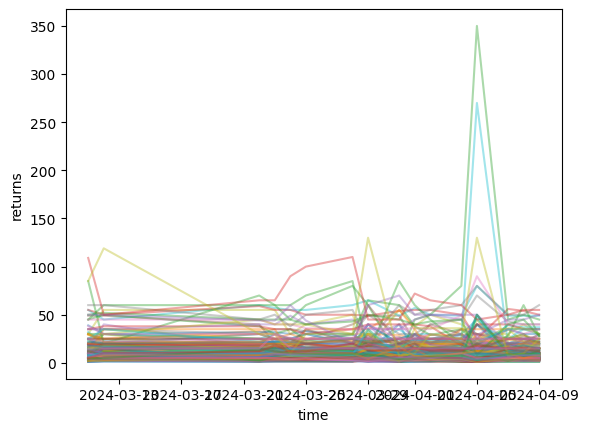

In [194]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')


for col in data.columns:
    data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))

plt.figure(figsize=(16, 10))
plt.plot(data, alpha=.4)
plt.xlabel('time')
plt.ylabel('returns')

Lets create several sample portfolios using the MPT formula and a generator function.

In [204]:
var_matrix = data.cov()

num_assets = len(data.columns)
num_port = 1000

port_weights = []
port_returns = []
port_volatility = []

# generator function, creates an iterator over the number of portfolios we want to generate
# its a better practice, specially if num_port -> inf
def generate_random_portfolios(num_port):
    num_assets = len(data.columns)
    var_matrix = data.cov()

    for _ in range(num_port):
        # each asset has either value 0 or 1
        weights = np.random.randint(0, 2, size=num_assets)
        # the returns of the portfolio is the matrix multiplication between (weights,)*(,expected_returns)
        returns = np.dot(weights, data.median())
        # portfolio variance is the double sum of covariance between assets as in the formula
        var = var_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        std = np.sqrt(var)

        yield weights, returns, std

for weights, returns, volatility in generate_random_portfolios(num_port):
    port_weights.append(weights)
    port_returns.append(returns)
    port_volatility.append(volatility)

In [205]:
new_data = {"Revenue": port_returns, 
            "Volatility": port_volatility}

for counter, symbol in enumerate(data.columns.tolist()):
    new_data[str(symbol)+'_weight'] = [w[counter] for w in port_weights]

portfolio = pd.DataFrame(new_data)
portfolio.head(10)

,Revenue,Volatility,11_weight,14_weight,18_weight,20_weight,22_weight,26_weight,87_weight,89_weight,97_weight,98_weight,119_weight,120_weight,123_weight,153_weight,156_weight,157_weight,158_weight,159_weight,163_weight,164_weight,165_weight,166_weight,176_weight,178_weight,179_weight,184_weight,185_weight,187_weight,189_weight,190_weight,191_weight,192_weight,194_weight,196_weight,197_weight,198_weight,199_weight,200_weight,...,2577_weight,2582_weight,2596_weight,2606_weight,2614_weight,2618_weight,2619_weight,2620_weight,2623_weight,2632_weight,2639_weight,2648_weight,2651_weight,2655_weight,2656_weight,2661_weight,2672_weight,2676_weight,2677_weight,2686_weight,2696_weight,2705_weight,2719_weight,2721_weight,2753_weight,2924_weight,2927_weight,2928_weight,2931_weight,2934_weight,2938_weight,2942_weight,2949_weight,2951_weight,2952_weight,2953_weight,2954_weight,2955_weight,2964_weight,2969_weight
0,1520.5625,155.975626,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,1,1,0,1,1,0,1,0,1,1,0,0,...,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,0,1,0,0
1,1846.0625,205.940920,1,1,1,0,0,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,1,1,0,1,1,0,1,1,0,1,0,1,0,0,1,1,0,1,...,1,0,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,1,0,1,1
2,1925.0625,131.791486,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,1,0,1,1,0,0,1
3,1614.1250,129.187138,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,1,1,1,0,1,1,0,0,1,...,0,1,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,1
4,1806.6250,129.083371,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,0,1,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,1,1,1
5,1624.5000,100.722060,0,0,0,0,1,1,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,1
6,1888.2500,163.936776,0,0,1,0,0,1,0,1,0,1,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,...,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,1,0
7,1736.1875,97.521429,1,1,1,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,1,0,1,1
8,1790.8125,207.828204,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,...,1,1,0,0,1,1,0,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,0
9,1584.1250,144.154951,1,1,1,0,1,1,0,0,1,0,1,0,1,1,0,1,1,0,0,1,1,0,1,0,0,0,1,1,1,0,1,1,1,0,1,1,1,1,...,0,1,0,1,0,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,0,1,1,1


In [206]:
# Create heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=portfolio.drop(columns=["Revenue", "Volatility"], axis = 1).head(50).values,
    x=portfolio.drop(columns=["Revenue", "Volatility"], axis = 1).head(50).columns,
    y=portfolio.drop(columns=["Revenue", "Volatility"], axis = 1).head(50).index,
    colorscale='YlGnBu',
    colorbar=dict(title='Number of products')
))

fig.update_layout(
    title='Sparse matrix (product distribution across portfolios)',
    xaxis_title='Catalog_id',
    yaxis_title='Number of sample portfolios'
)
fig


In [207]:
portfolio["Sharpe"] = portfolio["Revenue"]/portfolio["Volatility"]

fig = px.scatter(
    data_frame=portfolio,
    x='Volatility',
    y='Revenue',
    color='Sharpe',
    title='Scatter Plot of Portfolio',
    labels={'Volatility': 'Volatility (std)', 'Revenue': 'Expected Returns', 'Sharpe': 'Sharpe Ratio'},
    marginal_x='histogram',
    marginal_y='histogram', 
)

fig.update_layout(
    width=1200,  
    height=800,  
)

fig


In [208]:
histogram_trace = go.Histogram(
    x=portfolio['Sharpe'],  # 'column_name' contains the data you want to plot
    marker_color='skyblue',  # Optional: set color of bars
    opacity=0.7,  # Optional: set opacity of bars
)


layout = go.Layout(
    title='Distribution Plot',  # Set title of the plot
    xaxis=dict(title='Values'),  # Set label for x-axis
    yaxis=dict(title='Frequency'),  # Set label for y-axis
)

fig = go.Figure(data=[histogram_trace], layout=layout)
fig

In [209]:
z = portfolio.drop(["Volatility", "Revenue", "Sharpe"], axis=1).sum(axis = 1)

fig = px.scatter(
    data_frame=portfolio,
    x=z,
    y='Revenue',
    color='Sharpe',
    title='Revenue per Number of Articles',
    labels={'Volatility': 'Volatility (std)', 'Revenue': 'Expected Returns', 'Sharpe': 'Sharpe Ratio'}
)

fig.update_layout(
    width=1200,
    height=800,
)

fig

In [210]:
scatter3d_trace = go.Scatter3d(
    x=portfolio["Volatility"],
    y=portfolio["Revenue"],
    z=portfolio["Sharpe"],
    mode='markers',
    marker=dict(
        size=5,                    # Reduce the size of markers
        color=z,                   # Set color to be based on the z-values
        colorscale='Viridis',      # Choose a color scale
        opacity=0.8,
        line=dict(width=0.5, color='black')  # Add marker outline
    )
)

layout = go.Layout(
    title='Overview of Sharpe, Volatility and Revenue',
    scene=dict(
        xaxis=dict(title='Volatility'),
        yaxis=dict(title='Revenue'),
        zaxis=dict(title='Sharpe')
    )
)

fig = go.Figure(data=[scatter3d_trace], layout=layout)

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Volatility', tickfont=dict(size=10)),  # Adjust axis label font size
        yaxis=dict(title='Revenue', tickfont=dict(size=10)),      # Adjust axis label font size
        zaxis=dict(title='Sharpe', tickfont=dict(size=10)),  # Adjust axis label font size
        camera_eye=dict(x=1.2, y=1.2, z=1.2)  # Adjust camera position
    ),
)
fig

## Analysis of results

In [216]:
top_5_port = portfolio.sort_values("Sharpe", ascending=False).reset_index(drop= True).head(5)
top_5_port

,Revenue,Volatility,11_weight,14_weight,18_weight,20_weight,22_weight,26_weight,87_weight,89_weight,97_weight,98_weight,119_weight,120_weight,123_weight,153_weight,156_weight,157_weight,158_weight,159_weight,163_weight,164_weight,165_weight,166_weight,176_weight,178_weight,179_weight,184_weight,185_weight,187_weight,189_weight,190_weight,191_weight,192_weight,194_weight,196_weight,197_weight,198_weight,199_weight,200_weight,...,2582_weight,2596_weight,2606_weight,2614_weight,2618_weight,2619_weight,2620_weight,2623_weight,2632_weight,2639_weight,2648_weight,2651_weight,2655_weight,2656_weight,2661_weight,2672_weight,2676_weight,2677_weight,2686_weight,2696_weight,2705_weight,2719_weight,2721_weight,2753_weight,2924_weight,2927_weight,2928_weight,2931_weight,2934_weight,2938_weight,2942_weight,2949_weight,2951_weight,2952_weight,2953_weight,2954_weight,2955_weight,2964_weight,2969_weight,Sharpe
0,1600.5000,34.060730,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,...,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,46.989598
1,1754.3125,40.415704,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,43.406703
2,1668.1250,44.774807,1,1,1,0,1,1,0,1,1,0,1,0,1,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,...,0,1,1,1,0,1,1,1,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,1,1,1,0,0,1,1,0,1,1,1,0,1,37.255884
3,1398.5000,39.518772,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,...,0,1,0,0,0,1,1,1,0,1,1,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,35.388245
4,1663.6875,48.117521,0,1,1,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,0,...,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,34.575503


In [217]:
# Create heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=top_5_port.drop(columns=["Revenue", "Volatility", "Sharpe"], axis = 1).values,
    x=top_5_port.drop(columns=["Revenue", "Volatility", "Sharpe"], axis = 1).columns,
    y=top_5_port.drop(columns=["Revenue", "Volatility", "Sharpe"], axis = 1).index,
    colorscale='YlGnBu',
    colorbar=dict(title='Number of products')
))

fig.update_layout(
    title='Top 5 portfolio composition',
    xaxis_title='Catalog_id',
    yaxis_title='Index'
)
fig

In [223]:
statistics = portfolio[["Revenue", "Volatility", "Sharpe"]].describe()

# Style the DataFrame
styled_statistics = statistics.style \
    .format("{:.2f}") \
    .set_caption("Statistics for Portfolio") \
    .set_table_styles([{'selector': 'caption', 'props': [('color', 'red'), ('font-size', '16px')]}]) 

styled_statistics


,Revenue,Volatility,Sharpe
count,1000.00,1000.00,1000.00
mean,1743.30,128.95,15.18
std,131.86,42.92,5.57
min,1368.56,34.06,6.36
25%,1649.95,95.99,11.05
50%,1741.78,127.32,13.82
75%,1829.62,158.96,18.03
max,2165.75,259.30,46.99
